In [2]:

import numpy as np
import torch
from rocket import Rocket
# from TestNetwork import ActorCritic
# from PPO_network import VNetwork, PolicyNetwork
import matplotlib.pyplot as plt
import utils
import os
import glob
import time
import datetime
from collections import deque
import torch.optim as optim

import torch.nn as nn

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:

class PositionalMapping(nn.Module):
    """
    Positional mapping Layer.
    This layer map continuous input coordinates into a higher dimensional space
    and enable the prediction to more easily approximate a higher frequency function.
    See NERF paper for more details (https://arxiv.org/pdf/2003.08934.pdf)
    """

    def __init__(self, input_dim, L=5, scale=1.0):
        super(PositionalMapping, self).__init__()
        self.L = L
        self.output_dim = input_dim * (L*2 + 1)
        self.scale = scale

    def forward(self, x):

        x = x * self.scale

        if self.L == 0:
            return x

        h = [x]
        PI = 3.1415927410125732
        for i in range(self.L):
            x_sin = torch.sin(2**i * PI * x)
            x_cos = torch.cos(2**i * PI * x)
            h.append(x_sin)
            h.append(x_cos)

        return torch.cat(h, dim=-1) / self.scale

# Based on the code from https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/
# Network architecture and hyperparameters are based on : https://arxiv.org/pdf/2006.05990.pdf
# The code below is taken from: https://github.com/huggingface/deep-rl-class/blob/main/notebooks/unit8/unit8_part1.ipynb


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class VNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.mapping = PositionalMapping(input_dim=input_dim, L=7)
        self.critic = nn.Sequential(
            layer_init(nn.Linear(self.mapping.output_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
    def forward(self, x):
        x = x.view([1, -1])
        x = self.mapping(x)
        x = self.critic(x)
        return x


class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.mapping = PositionalMapping(input_dim=input_dim, L=7)
        self.actor = nn.Sequential(
            layer_init(nn.Linear(self.mapping.output_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, output_dim), std=1.0),
        )
        
    def forward(self, x):
        x = x.view([1, -1])
        x = self.mapping(x)
        x = self.actor(x)
        x = torch.nn.functional.softmax(x, dim=-1)
        return x


def gen_episode(environment, policy_target, device, max_step = 800):
    states = []
    actions = []
    rewards = []
    ratios = []
    state = environment.reset() 
    terminated = False

    for step in range(max_step):
        probs_target = policy_target(torch.FloatTensor(state).to(device))
        action = torch.multinomial(probs_target, 1).item()
        
        next_state, reward, terminated, _ = environment.step(action) 
        #must add:
#         env.render()
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        if terminated:
            break  
        
        state = next_state
    return states, actions, rewards


In [3]:
task = 'hover'  # 'hover' or 'landing'
version = 5

max_m_episode = 200000
max_steps = 800
     #network and optimizer

    #hyperparameters:
alpha = 2.5e-4
gamma = 0.99
lmbda         = 0.99
eps_clip      = 0.1
K_epoch       = 4

env = Rocket(task=task, max_steps=max_steps)


    #create networks:
pi = PolicyNetwork(env.state_dims, env.action_dims)
pi_optimizer = torch.optim.Adam(pi.parameters(), lr=alpha)
pi_target = PolicyNetwork(env.state_dims, env.action_dims)

V = VNetwork(env.state_dims)
V_optimizer = torch.optim.Adam(V.parameters(), lr=alpha)  

V = V.to(device)
pi = pi.to(device)
pi_target = pi_target.to(device)

    
ckpt_folder = os.path.join('./', task + '_ckpt')
if not os.path.exists(ckpt_folder):
    os.mkdir(ckpt_folder)

In [4]:
episode = 0
MAX_EPISODES = 20000
reward_history =[]
reward_history_100 = deque(maxlen=100)

while episode < MAX_EPISODES:  # episode loop
        
    pi_target.load_state_dict(pi.state_dict())
    states, actions, rewards = gen_episode(env, pi_target, device, max_steps)
            
    episode += 1    
    for k in range(1,K_epoch):
        loss1 = 0
        loss2 = 0
        GAE = 0
        G = 0
        for t in range(len(states) - 2, -1, -1):
            S = states[t]
            A = actions[t]
            R = rewards[t]
            S_next = states[t+1]
                
            S=torch.FloatTensor(S).to(device)
            A=torch.tensor(A, dtype=torch.int8).to(device)
            S_next=torch.FloatTensor(S_next).to(device)
                
            with torch.no_grad():
                delta = R + gamma*V(S_next)-V(S)
                GAE = gamma * lmbda * GAE + delta           
                G = gamma * G + R

                # actor_output = pi(S)[A]
                # actor_target_output = pi_target(S)[A]

            actor_output = pi(S)
            actor_target_output = pi_target(S)
            actor_output = actor_output.view(-1).to(device)
            actor_target_output = actor_target_output.view(-1).to(device)

                
                
                # ratio = pi(S)[A]/pi_target(S)[A]
            ratio = actor_output[A] / actor_target_output[A]
                # print("ratio:", ratio)
            surr1 = ratio * (gamma**t)* GAE
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * (gamma**t)* GAE 
            loss1 = loss1 - torch.min(surr1, surr2)
            loss2 = loss2 + (G - V(S))**2
        loss2 = loss2/len(states)
                
        pi_optimizer.zero_grad()
        loss1.backward()
        pi_optimizer.step()
            
        V_optimizer.zero_grad()
        loss2.backward()
        V_optimizer.step() 
    
    reward_history.append(G)
        # reward_history_100.append(G)
        # avg = sum(reward_history_100) / len(reward_history_100)

    if episode % 10 == 1:
        print('episode id: %d, episode return: %.3f'
                % (episode, G))
        plt.figure()
        plt.plot(reward_history), plt.plot(utils.moving_avg(reward_history, N=50))
        plt.legend(['episode reward', 'moving avg'], loc=2)
        plt.xlabel('m episode')
        plt.ylabel('return')
        plt.savefig(os.path.join(ckpt_folder, 'rewards_' + str(version).zfill(8) + '.jpg'))
        plt.close()

        torch.save({'episode_id': episode,
                            'REWARDS': reward_history,
                            'model_pi_state_dict': pi.state_dict(),
                            'model_V_state_dict': V.state_dict()},
                           os.path.join(ckpt_folder, 'ckpt_' + str(version).zfill(8) + '.pt'))


episode id: 1, episode return: 8.997
episode id: 11, episode return: 8.047
episode id: 21, episode return: 9.773
episode id: 31, episode return: 7.335
episode id: 41, episode return: 11.566
episode id: 51, episode return: 13.060
episode id: 61, episode return: 14.306
episode id: 71, episode return: 9.152
episode id: 81, episode return: 11.328
episode id: 91, episode return: 8.626
episode id: 101, episode return: 9.143
episode id: 111, episode return: 10.318
episode id: 121, episode return: 8.934
episode id: 131, episode return: 13.751
episode id: 141, episode return: 9.698
episode id: 151, episode return: 10.168
episode id: 161, episode return: 14.915
episode id: 171, episode return: 16.563
episode id: 181, episode return: 14.339
episode id: 191, episode return: 5.676
episode id: 201, episode return: 7.421
episode id: 211, episode return: 11.195
episode id: 221, episode return: 17.892
episode id: 231, episode return: 13.511
episode id: 241, episode return: 17.492
episode id: 251, episo

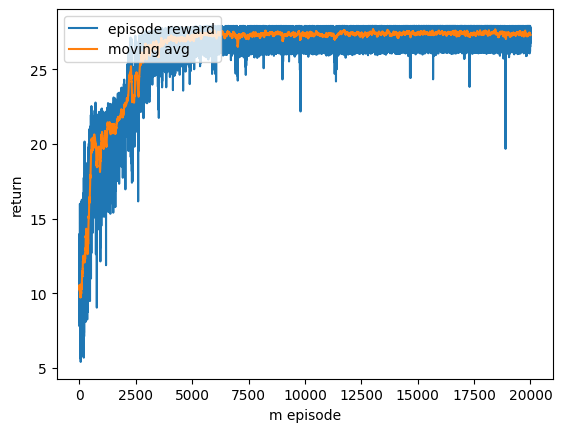

In [5]:
plt.plot(reward_history), plt.plot(utils.moving_avg(reward_history, N=50))
plt.legend(['episode reward', 'moving avg'], loc=2)
plt.xlabel('m episode')
plt.ylabel('return')
plt.show()

In [8]:
task = 'hover'  # 'hover' or 'landing'
max_steps = 800
gamma = 0.99
ckpt_dir = glob.glob(os.path.join(task+'_ckpt', '*.pt'))[-1]  # last ckpt

print(ckpt_dir)
env_test = Rocket(task=task, max_steps=max_steps)
pi_test = PolicyNetwork(env_test.state_dims, env_test.action_dims)
pi_test = pi_test.to(device)
    
if os.path.exists(ckpt_dir):
    checkpoint = torch.load(ckpt_dir, map_location=torch.device(device))
    pi_test.load_state_dict(checkpoint['model_pi_state_dict'])

state = env_test.reset()
episode_returns = list()
for i in range(100):
    _, _, rewards = gen_episode(env_test, pi_test, device, max_steps)
    G = 0
    for t in range(len(rewards) - 2, -1, -1):
        R = rewards[t]
        G = gamma * G + R

    episode_returns.append(G)

average_return = sum(episode_returns) / len(episode_returns)
print(average_return / 17)

hover_ckpt/ckpt_00000005.pt
1.6152465313460591
